In [4]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKModel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Consumption-Saving Model with Endogenous Labor Supply


In [5]:
model = HANKModelClass(name='baseline')

In [6]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [w,r,d,tau]
 inputs_hh_z: []
 outputs_hh: [a,c,ell,n]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Z,istar,G]
 unknowns: [Y,w,pi]
 targets: [NKPC_res,clearing_N,clearing_A]

blocks (inputs -> outputs):
 production: [Z,w,Y] -> [N,s]
 taylor: [istar,pi,Y] -> [i]
 fisher: [i,pi] -> [r]
 government: [G,r] -> [B,tau]
 intermediary_goods: [r,s,Y,pi] -> [NKPC_res,adjcost,d]
 hh: [d,r,tau,w] -> [A_hh,C_hh,ELL_hh,N_hh]
 market_clearing: [B,N,Y,G,adjcost,N_hh,A_hh,C_hh] -> [A,clearing_N,clearing_A,clearing_Y]


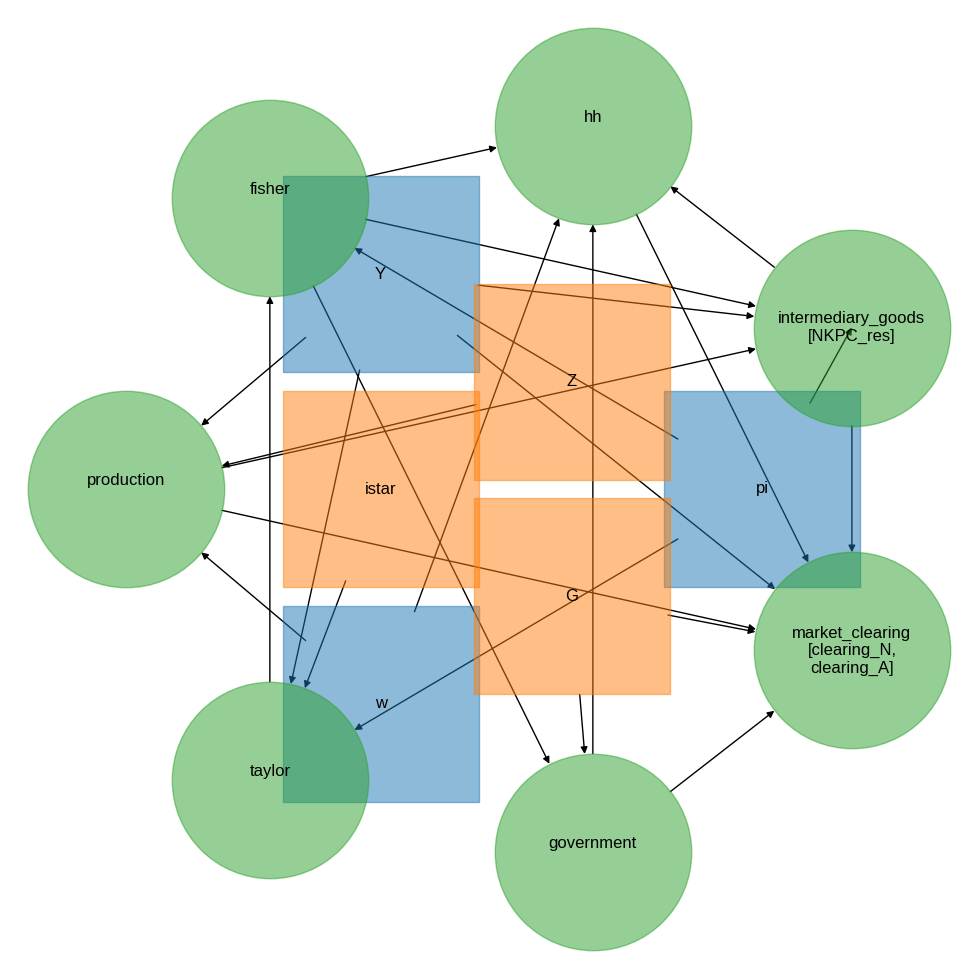

In [8]:
model.draw_DAG(figsize=(10,10),order=['shocks','unknowns','blocks'])

In [9]:
model.find_ss(do_print=True)

In [ ]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [ ]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

In [ ]:
model_ = model.copy()
model_.par.phi_y = 1.0
model_.compute_jacs()
model_.find_transition_path(shocks=['istar'])

In [ ]:
paths = ['i','r','tau','C_hh','Y','N','pi','w','d','N_hh','clearing_Y']
lvl_value = ['i','pi','r','istar','G','clearing_Y']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

In [ ]:
paths = ['r','C_hh']
model.compare_IRFs([model,model_],['baseline','alt.'],
                   paths,lvl_value,do_shocks=False,do_targets=False,ncols=2)

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C_hh')
    ax.plot(ss.C_hh+sim.dC_hh,ls='--',)
    ax.axhline(ss.C_hh,color='black',zorder=0)

In [ ]:
model_sim()

In [ ]:
T_max = 50

fig_C = plt.figure(figsize=(6,4),dpi=100)
ax_C = fig_C.add_subplot(1,1,1)
ax_C.set_title('consumption, $C_t^{hh}$')
               
fig_N = plt.figure(figsize=(6,4),dpi=100)
ax_N = fig_N.add_subplot(1,1,1)
ax_N.set_title('labor supply, $N_t^{hh}$')
               
i_color = 0
for use_inputs in [[x] for x in model.inputs_hh]:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax_C.plot((path_alt.C_hh[:T_max]/ss.C_hh-1)*100,ls=ls,color=color,label=label);
    ax_N.plot((path_alt.N_hh[:T_max]/ss.N_hh-1)*100,ls=ls,color=color,label=label);    

for ax in [ax_C,ax_N]:
    ax.set_ylabel('% diff to s.s.')
    lgd = ax.legend(frameon=True,ncol=1,bbox_to_anchor=(1.05,1), loc='upper left',)

plt.show()